# Data Visualisation, Prepocessing and Some Baseline Models

---



In [1]:
import numpy as np
import datetime as dt
import pandas
import time
import random
import matplotlib
import pandas as pd
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

In [ ]:
# Code snippet taken from class material
def getfile(gdrive,**kwargs): #tries to get local version and then defaults to google drive version
    loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
    out=pandas.read_pickle(loc, **kwargs)
    return out

### Import the Features
Here we import the features saved as binary files in the project folder. We have identified that gasoline prices are primarily driven by classical economic theory of supply and demand. The supply of gasoline to the US is primarily from domestic crude oil wells and imports from other nations. The US also maintains a strategic petroleum reserve to handle the disruptions in the crude oil supply chain. Demand of gasoline is primarily reflected by domestic consumption. Other than these, inflation limits the purchasing power thus affecting both production/import and consumtion of gasoline. It is usually measured as Consumer Price Index (CPI) by the Federal Bank of the US. Further, changes in taxation at federal and state level will also impact the prices, however it remains constant over a long duration. Finally, we will also use historical trends in gasoline prices to capture any missing features. To summarize, we are building a Recurrent Neural Network (RNN) to predict the weekly gasoline price based on the following features:


1.   Weekly crude oil import (Supply)
2.   Strategic Petroleum Reserve (Supply)
3.   Domestic Production (Supply)
4.   Domestic Consumption of Gas (Demand)
5.   Domestic Inflation as CPI
6.   Historical Price of Gasoline

We first load the data from pickle files saved on the google drive folder.

In [ ]:
data = {}

# CPI
fname = "https://drive.google.com/file/d/1-CKtjFCPXvt1VHtMGhIZX3ew0yGD4kqA/view?usp=share_link"
data['CPI'] = getfile(fname)
data['CPI'] = data['CPI'].reset_index(drop=True)
data['CPI'] = data['CPI'].rename(columns={"Yearmon": "Date"})
data['CPI']['Date'] = data['CPI']['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%d-%m'))
data['CPI']['Date'] = pandas.to_datetime(data['CPI']['Date'])
print(data['CPI'].head())

# Consumption
fname = "https://drive.google.com/file/d/196YZI2degsMUuY2B_dGedX2dn7YqN8eA/view?usp=share_link"
data['Consumption'] = getfile(fname)
data['Consumption'] = data['Consumption'].rename(columns={"Week of": "Date"})
print(data['Consumption'].head())

# Price
fname = "https://drive.google.com/file/d/1xZTHOvRw8dI2ZOQ2GQqa5TeEV9m7WLZ0/view?usp=share_link"
data['Price'] = getfile(fname)
print(data['Price'].head())

# Imports
fname = "https://drive.google.com/file/d/10WJGO-BH3OLLMHHVtHHek4O-odPvsJyP/view?usp=share_link"
data['NetImports'] = getfile(fname)
print(data['NetImports'].head())

# Reserve
fname = "https://drive.google.com/file/d/1TK9W9xA9tOH5qfjlmbh49L13Grj52u6f/view?usp=share_link"
data['Reserve'] = getfile(fname)[::-1]
data['Reserve'] = data['Reserve'].rename(columns={"Month": "Date"})
print(data['Reserve'].head())

# Production
fname = "https://drive.google.com/file/d/12RZ5g-tlhVPQH5hMEgMoJOXFtXG_cL35/view?usp=share_link"
data['Production'] = getfile(fname)[::-1]
data['Production'] = data['Production'].rename(columns={"Month": "Date"})
print(data['Production'].head())

        Date   CPI
0 1975-07-01  54.2
1 1975-08-01  54.3
2 1975-09-01  54.6
3 1975-10-01  54.9
4 1975-11-01  55.3
        Date  \
0 1991-02-08   
1 1991-02-15   
2 1991-02-22   
3 1991-03-01   
4 1991-03-08   

   Weekly U.S. Product Supplied of Finished Motor Gasoline Thousand Barrels per Day  
0                                               6621                                 
1                                               6433                                 
2                                               6582                                 
3                                               7224                                 
4                                               6875                                 
        Date  Price
0 1993-04-05  1.068
1 1993-04-12  1.079
2 1993-04-19  1.079
3 1993-04-26  1.086
4 1993-05-03  1.086
        Date  \
0 1991-02-08   
1 1991-02-15   
2 1991-02-22   
3 1991-03-01   
4 1991-03-08   

   Weekly U.S. Net Imports of Crude Oil and Petroleum Pr

### Find a common starting time for all data

We then truncate the data based on the available price data. We discard all of the data with an earlier date than the date of the first price data point.

In [ ]:
for feature in ['Production', 'CPI', 'NetImports', 'Reserve', 'Consumption']:
  data[feature] = data[feature].loc[data[feature].iloc[: , 0] > (data['Price'].iloc[0 , 0] - pandas.offsets.Day(12))].reset_index(drop=True)

### Match features to the price data

Next, we match each price data-point with the feature data-points which have a date closest to the date of the price data-point. We note that we only consider feature data-points with an earlier date.

In [ ]:
data_list = []
for index, row in data['Price'].iterrows():
  for feature in ['Production', 'CPI', 'NetImports', 'Reserve', 'Consumption']:
    x = data[feature].loc[(data[feature]['Date'] < row['Date'])]
    row[feature] = x.loc[(x['Date'] - row['Date']).abs().idxmin()].iloc[1]

  data_list.append(row)

### Convert dataset into a Pandas Data Frame

In [ ]:
dataset = pandas.DataFrame(data_list)

### Normalize data
z-scoring the data

In [ ]:
dataset_norm = dataset.copy()
dataset_norm.iloc[: , 1:] = (dataset_norm.iloc[: , 1:] - dataset_norm.iloc[: , 1:].mean()) / dataset_norm.iloc[: , 1:].std()
(dataset_norm).head()

,Date,Price,Production,CPI,NetImports,Reserve,Consumption
0,1993-04-05,-1.315651,-0.209089,-1.664355,-0.303166,-0.972198,-2.669643
1,1993-04-12,-1.303821,-0.209089,-1.664355,0.076097,-0.972198,-2.921803
2,1993-04-19,-1.303821,-0.209089,-1.664355,-0.179352,-0.972198,-1.768210
3,1993-04-26,-1.296293,-0.209089,-1.664355,0.013277,-0.972198,-2.023389
4,1993-05-03,-1.296293,-0.124841,-1.659050,0.197825,-0.965331,-1.905614


### Visualize the dataset

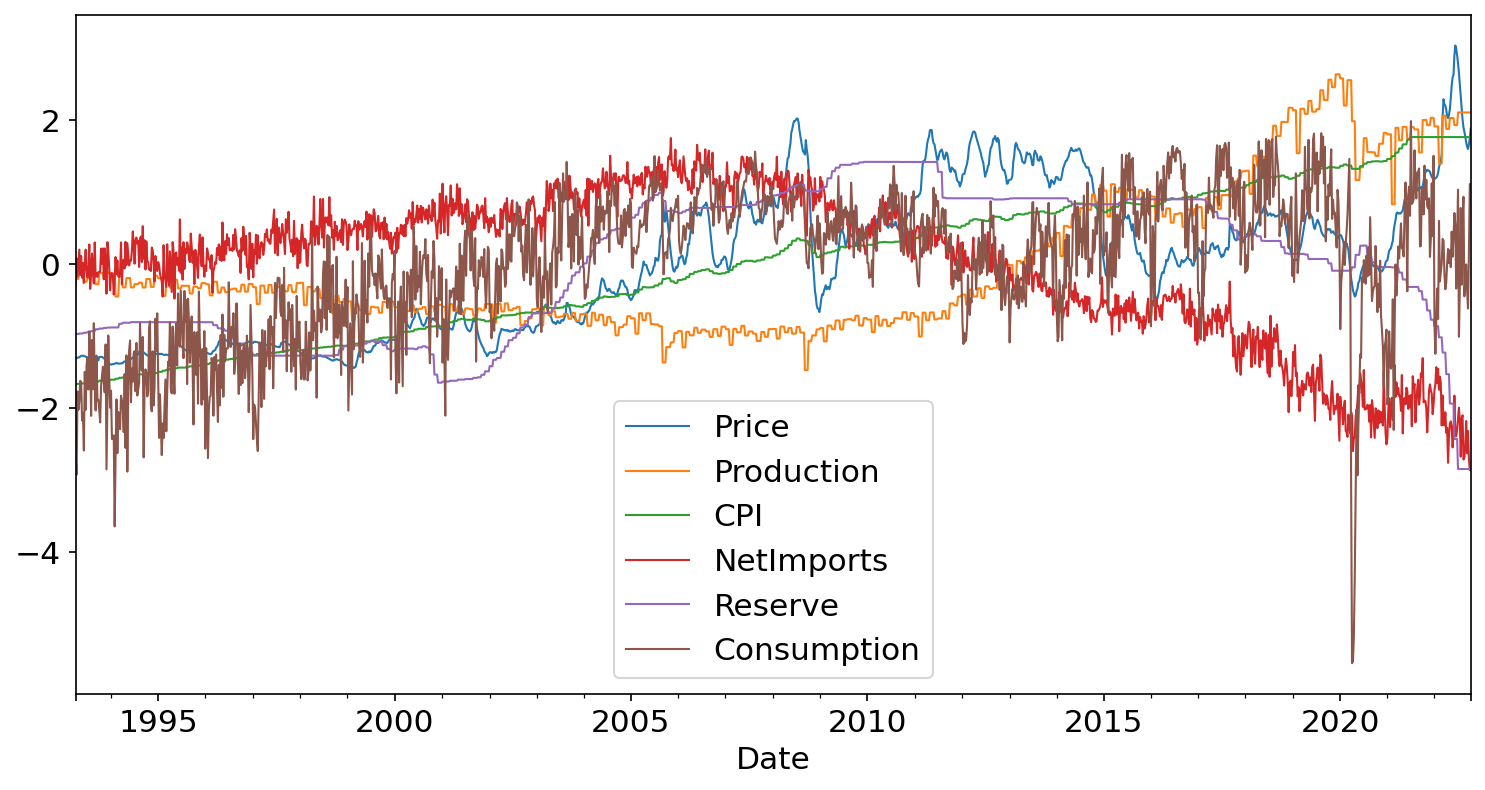

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
df = dataset_norm.plot(x='Date', linewidth=1, ax = plt.gca())

# plt.plot(dataset.iloc[: , 0], (dataset.iloc[: , 1:] - dataset.iloc[: , 1:].mean()) / dataset.iloc[: , 1:].std(), linewidth=1)
# plt.legend()
# plt.show()

## Train-Test Split

Before we extract any information from the data we split them into train and test data. We take the last 20% of the data as the test set. The analysis that follows is performed on the train data.

In [ ]:
trainset = dataset[:-int(0.2 * len(dataset))].copy()
testset = dataset[-int(0.2 * len(dataset)):].copy()

print(len(trainset), len(testset), len(dataset))

1233 308 1541


Normalize the train data, as well as the test data based on the mean and std values of the train data.

In [ ]:
trainset_norm = trainset.copy()
trainset_norm.iloc[: , 1:] = (trainset_norm.iloc[: , 1:] - trainset_norm.iloc[: , 1:].mean()) / trainset_norm.iloc[: , 1:].std()
print(trainset_norm.head())

testset_norm = testset.copy()
testset_norm.iloc[: , 1:] = (testset_norm.iloc[: , 1:] - trainset.iloc[: , 1:].mean()) / trainset.iloc[: , 1:].std()
print(testset_norm.head())

        Date     Price  Production       CPI  NetImports   Reserve  \
0 1993-04-05 -1.151512    0.394342 -1.637237   -1.209745 -0.972867   
1 1993-04-12 -1.139770    0.394342 -1.637237   -0.563829 -0.972867   
2 1993-04-19 -1.139770    0.394342 -1.637237   -0.998879 -0.972867   
3 1993-04-26 -1.132299    0.394342 -1.637237   -0.670816 -0.972867   
4 1993-05-03 -1.132299    0.550456 -1.630679   -0.356515 -0.966205   

   Consumption  
0    -2.698781  
1    -2.962563  
2    -1.755797  
3    -2.022738  
4    -1.899535  
           Date     Price  Production       CPI  NetImports   Reserve  \
1233 2016-11-21  0.130415    2.022533  1.554768   -1.820590  0.838477   
1234 2016-11-28  0.129347    2.022533  1.554768   -1.891618  0.838477   
1235 2016-12-05  0.185918    2.188713  1.557358   -1.771758  0.838445   
1236 2016-12-12  0.213670    2.188713  1.557358   -2.503795  0.838445   
1237 2016-12-19  0.243557    2.188713  1.557358   -1.973745  0.838445   

      Consumption  
1233     0.555067 

# Linear Regression Baseline

---



We use linear regression as a baseline model. First we train a linear regression model on the features which do not contain historic price data and then on the features containing the price of the previous week.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import svm

y_train = trainset_norm.iloc[: , 1].to_numpy()
X_train = trainset_norm.iloc[: , 2:].to_numpy()

y_test = testset_norm.iloc[: , 1].to_numpy()
X_test = testset_norm.iloc[: , 2:].to_numpy()

reg = LinearRegression().fit(X_train, y_train)
y_train_hat = reg.predict(X_train)
y_test_hat = reg.predict(X_test)

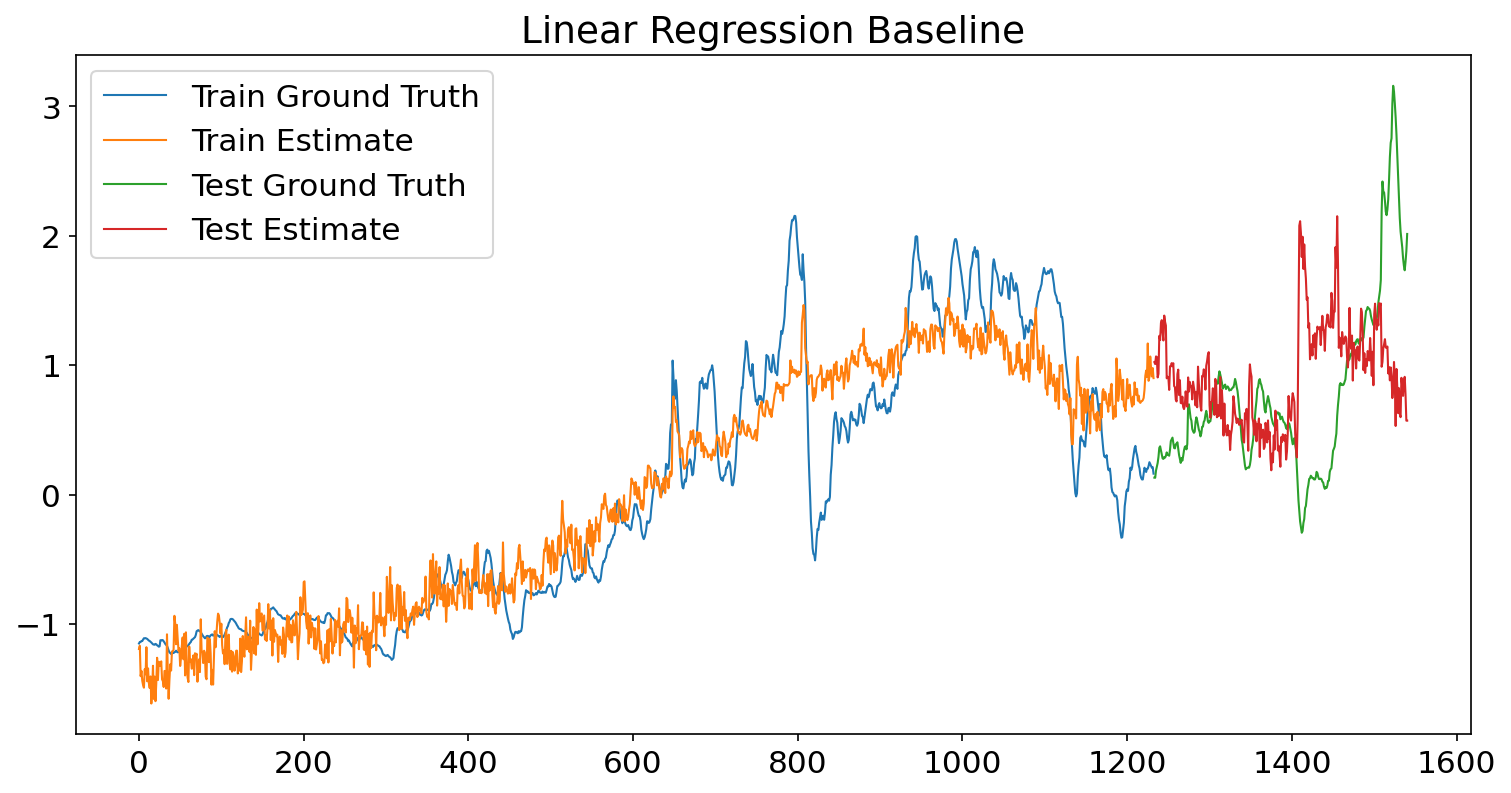

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(y_train, linewidth=1, label='Train Ground Truth')
plt.plot(y_train_hat, linewidth=1, label='Train Estimate')
plt.plot(np.arange(len(y_test))+len(y_train), y_test, linewidth=1, label='Test Ground Truth')
plt.plot(np.arange(len(y_test))+len(y_train), y_test_hat, linewidth=1, label='Test Estimate')
plt.title('Linear Regression Baseline')
plt.legend()
plt.show()

Next we augment the features, by adding as a feature the price of the previous week. We observe that the performance is greatly improved both on the train set and test set.

In [ ]:
train_df = pd.concat([trainset_norm, trainset_norm['Price'].shift(1)], axis=1, ignore_index=True)[1:]

y_train = train_df.iloc[: , 1].to_numpy()
X_train = train_df.iloc[: , 2:].to_numpy()

test_df = pd.concat([testset_norm, testset_norm['Price'].shift(1)], axis=1, ignore_index=True)[1:]

y_test = test_df.iloc[: , 1].to_numpy()
X_test = test_df.iloc[: , 2:].to_numpy()

reg = LinearRegression().fit(X_train, y_train)
y_train_hat = reg.predict(X_train)
y_test_hat = reg.predict(X_test)

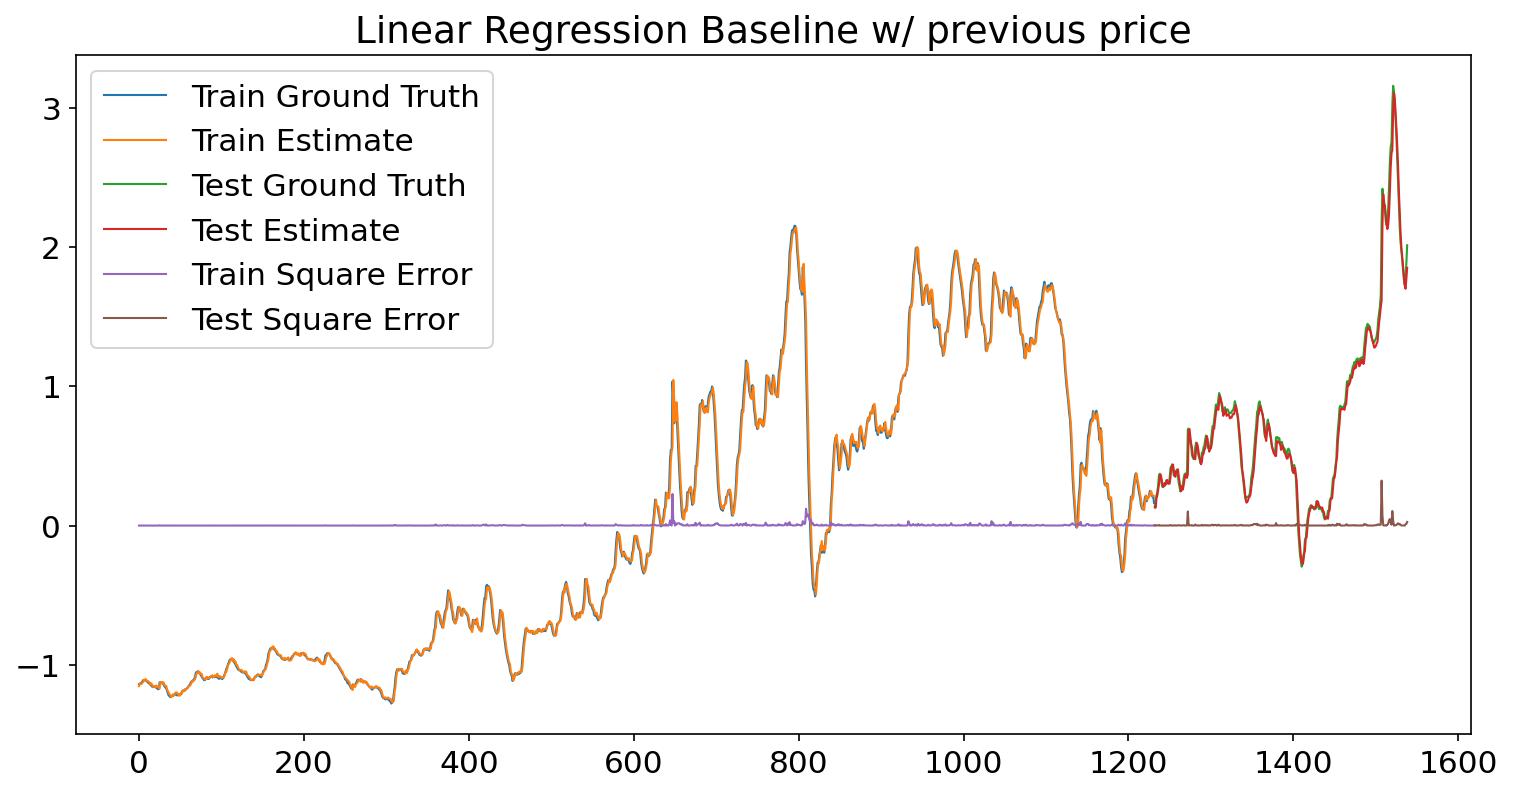

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(y_train, linewidth=1, label='Train Ground Truth')
plt.plot(y_train_hat, linewidth=1, label='Train Estimate')
plt.plot(np.arange(len(y_test))+len(y_train), y_test, linewidth=1, label='Test Ground Truth')
plt.plot(np.arange(len(y_test))+len(y_train), y_test_hat, linewidth=1, label='Test Estimate')
plt.plot((y_train - y_train_hat)**2, linewidth=1, label='Train Square Error')
plt.plot(np.arange(len(y_test))+len(y_train), (y_test - y_test_hat)**2, linewidth=1, label='Test Square Error')
plt.title('Linear Regression Baseline w/ previous price')
plt.legend()
plt.show()

The fact that the fitting improves substantially once historic data of the price itself is added as a feature shows the necessity of a long/short term memory of the price value

## Feature Importance

---



First before we identify the heirarchy of features, we need to isolate the seasonality and trends in the features. Check for correlations between the features and then decide on appropriate analysis methods to identify feature importance 

### Correlation between features

Some of the chosen features have strong correlation. For example a simple Pearson correlation analysis shows that Net Imports and Production are 0.86 directly related. Here is the correlation matrix with the seasonality and trends intact and not separated from the data

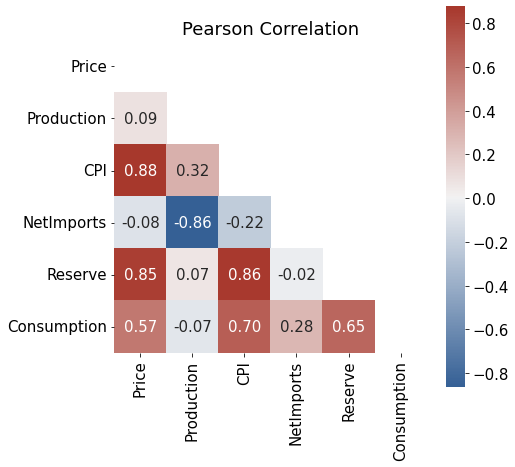

In [ ]:
import seaborn as sns

cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True) # Create a custom palette
matrix = trainset_norm.corr(method="pearson") # Compute corr matrix
mask = np.triu(np.ones_like(matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.title('Pearson Correlation')
plt.show()


### Seasonality

The feature data used has seasonality on two levels: monthly and annual. Currently annual seasonality is identified and removed from data to isolate trends

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f049a2e95e0>,
      dtype=object)

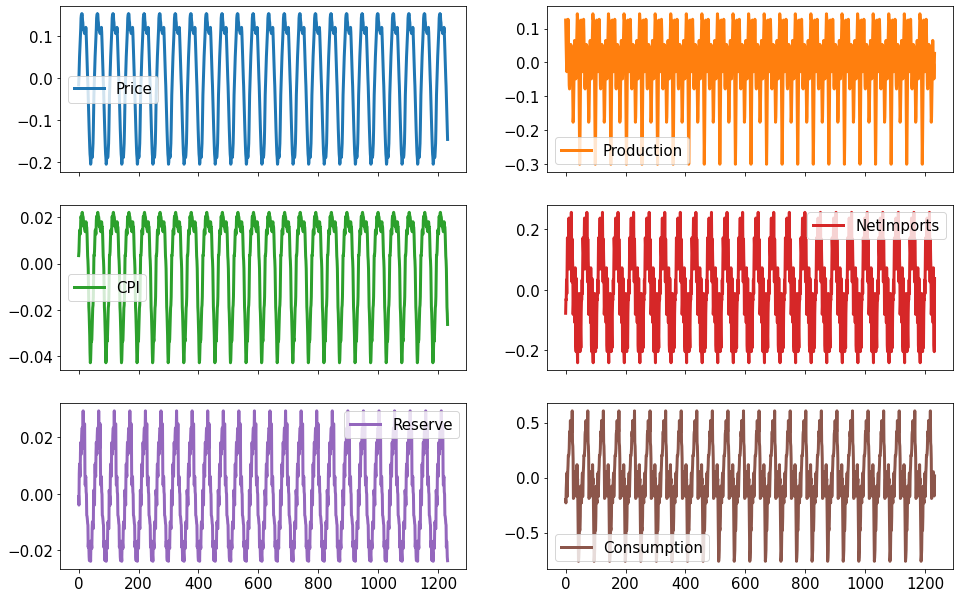

In [ ]:
import statsmodels.api as sm
import pandas as pd
from matplotlib import rcParams

seasonality_dict = {}
decompfreq = 52 #A year as our 'season'
for ts in range(1,len(dataset_norm.columns),1):
    decompositions = sm.tsa.seasonal_decompose(trainset_norm[trainset_norm.columns[ts]].dropna(), period=decompfreq)
    # Store the results back
    seasonality_dict[trainset_norm.columns[ts]] = decompositions.seasonal
# Plot seasonality
rcParams["figure.figsize"] = 16, 14
pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(4, 2), linewidth=3)

Showing correlation in the seasonality of the features

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


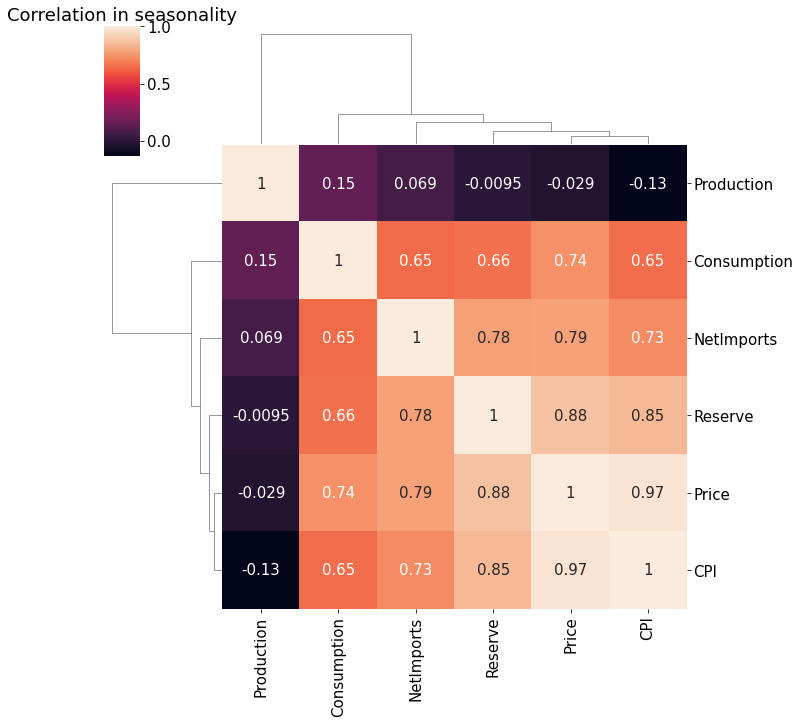

In [ ]:
#Correlation in seasonality
seasonality_dict = {trainset_norm.columns[ts]: sm.tsa.seasonal_decompose(trainset_norm[trainset_norm.columns[ts]].dropna(),period=decompfreq).seasonal for ts in range(1,len(trainset_norm.columns),1)}
seasonality_corr = pd.DataFrame(seasonality_dict).corr() # Compute corr matrix
sns.clustermap(seasonality_corr, annot=True, square=True)
plt.title('Correlation in seasonality')
plt.show()

### Trends

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f049a28fd60>,
      dtype=object)

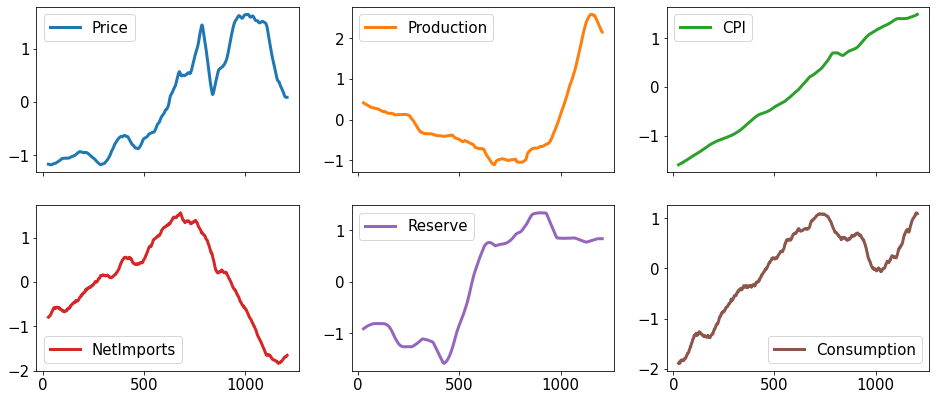

In [ ]:
N =4 #Smoothing trends over a month
trend_dict = {}
trend_dictoriginal= {}
for ts in range(1,len(trainset_norm.columns),1):
    decompositions = sm.tsa.seasonal_decompose(trainset_norm[trainset_norm.columns[ts]].dropna(),period=decompfreq)
    # Store back the results
    trend_dict[ts] = pd.Series(decompositions.trend).rolling(window=N).mean().iloc[N-1:]
    trend_dictoriginal[trainset_norm.columns[ts]]=decompositions.trend
#Plot Trends
pd.DataFrame(trend_dictoriginal).plot(subplots=True, layout=(4, 3), linewidth=3)

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


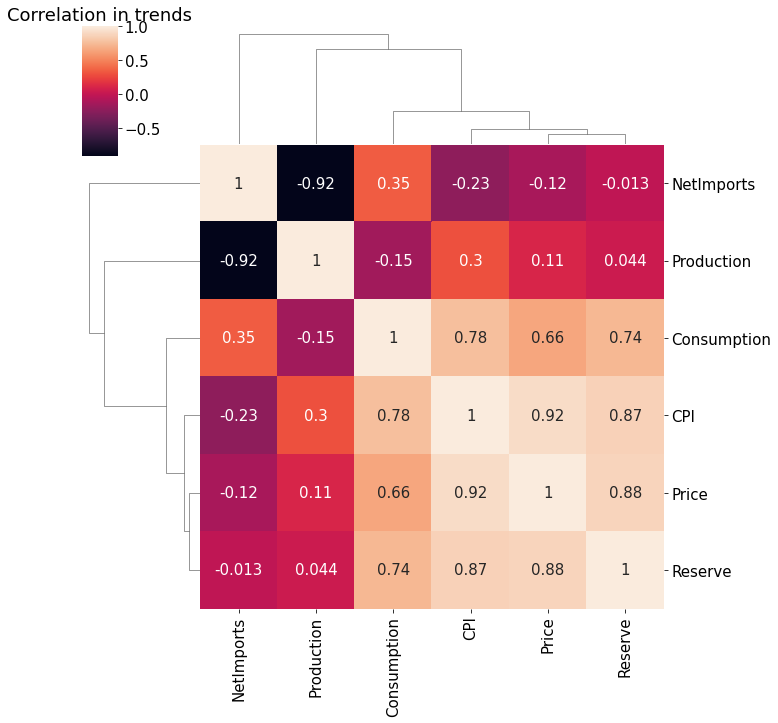

In [ ]:
#Correlation in trends
trend_dict = {trainset_norm.columns[ts]: pd.Series(sm.tsa.seasonal_decompose(trainset_norm[trainset_norm.columns[ts]].dropna(),period=decompfreq).trend).rolling(window=N).mean().iloc[N-1:] for ts in range(1,len(trainset_norm.columns),1)}
trend_dict = pd.DataFrame(trend_dict).corr()
sns.clustermap(trend_dict, annot=True, square=True)
plt.title('Correlation in trends')
plt.show()

Price is most correlated with CPI. As seen in the plots, the CPI trace shows proportinal perturbations exactly when the price is perturbed across the entire range. Other features do not correlate well with price beyond ~ 650 weeks. 

**Based on Pearson correlation the feature importance is:
 CPI > Reserve > Consumption**

### Additional Feature Importance Analysis

Since the feaures used are codependant as seen in Pearson correlation analysis we try a couple of different methods to identify feature importance 

#### *Test-1 ANOVA statistical test*

In [ ]:
#Importing necessary libraries and modules
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [ ]:
X_all = dataset_norm.loc[:, ["Production", "CPI", "NetImports", "Reserve", "Consumption"]]
Y_all = dataset_norm.loc[:,["Price"]]

test = SelectKBest(score_func = f_classif, k = 3) #K is number of features selected
fit1 = test.fit(X_all, Y_all.values.ravel())
set_printoptions(precision = 3)
features = fit1.transform(X_all)

ANOVA_features_for_training = test.fit_transform(X_all,Y_all.values.ravel())
ANOVA_support = test.get_support()
ANOVA_feature = X_all.loc[:,ANOVA_support].columns.tolist()

print('The ordered feature list based on importance is:', ANOVA_feature)


The ordered feature list based on importance is: ['CPI', 'Reserve', 'Consumption']


### *Test-2 Recursive Feature Elimination*

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest

In [ ]:
model = LinearRegression()
rfe = RFE(model)

rfe_training = rfe.fit_transform(X_all,Y_all)
rfe_support = rfe.get_support()
rfe_feature = pd.DataFrame(X_all).loc[:,rfe_support].columns.to_list()

print('The feaures of importance are', rfe_feature)



The feaures of importance are ['Production', 'CPI']


Since production, reserve and consumption have correlations, this analysis elininates them and deems production representative. CPI is an independent feature 

###*Test-3 Principal Component Analysis*

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
data_PCA = dataset_norm.loc[:, ["Production", "CPI", "NetImports", "Reserve", "Consumption"]]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(data_PCA)

pca = PCA(n_components = 0.95)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)
pca = PCA().fit(data_rescaled)


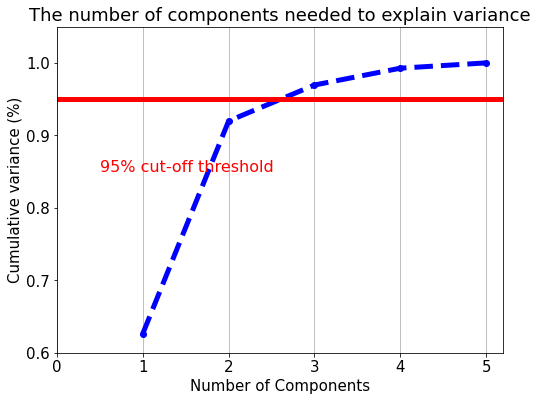

The model requires 3 components to successfully explain the variance in price


In [ ]:
pca = PCA().fit(data_rescaled)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(y)+1, step=1)

plt.ylim(0.6,1.05)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, max(xi)+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

print("The model requires 3 components to successfully explain the variance in price")

In [ ]:
print(data_PCA.columns)
print(abs( pca.components_ ))

Index(['Production', 'CPI', 'NetImports', 'Reserve', 'Consumption'], dtype='object')
[[0.529 0.679 0.453 0.19  0.131]
 [0.37  0.269 0.371 0.758 0.282]
 [0.063 0.273 0.313 0.55  0.722]
 [0.534 0.608 0.016 0.295 0.508]
 [0.543 0.151 0.747 0.024 0.352]]


Based on the principal component (rows) the largest values in each row correspond to:
**CPI> Reserve> Consumption**

***All the tests arrive at CPI as being the most important feature when using linear fitting.***

#Long/Short Term Memory Flavored RNN

---



First we split the data into train-val-test and z-score them. We use the mean and std of the train data to normalize the val and test splits.

In [ ]:
# Train-Val-Test Split
trainvalset = dataset[:-int(0.1 * len(dataset))].copy()
trainset = trainvalset[:-int(0.2 * len(dataset))].copy()
valset = trainvalset[-int(0.2 * len(dataset)):].copy()
testset = dataset[-int(0.1 * len(dataset)):].copy()

print('Dataset Size:', len(dataset))
print('Split Sizes')
print('Train Set:', len(trainset), 'Val Set:', len(valset), 'Test Set:', len(testset)) 

# Z-score train data
trainset_norm = trainset.copy()
trainset_norm.iloc[: , 1:] = (trainset_norm.iloc[: , 1:] - trainset_norm.iloc[: , 1:].mean()) / trainset_norm.iloc[: , 1:].std()
# print(trainset_norm.head())

# Z-score validation data (based on trainset mean and std)
valset_norm = valset.copy()
valset_norm.iloc[: , 1:] = (valset_norm.iloc[: , 1:] - trainset.iloc[: , 1:].mean()) / trainset.iloc[: , 1:].std()
# print(valset_norm.head())

# Z-score test data (based on trainset mean and std)
testset_norm = testset.copy()
testset_norm.iloc[: , 1:] = (testset_norm.iloc[: , 1:] - trainset.iloc[: , 1:].mean()) / trainset.iloc[: , 1:].std()
# print(testset_norm.head())

Dataset Size: 1541
Split Sizes
Train Set: 1079 Val Set: 308 Test Set: 154


Since the linear regression model worked best when shifted price data was added, it is clear a short-term memory of the price data would improve prediction capability. So to imporve the prediction we use LSTM (Long/Short Term Memory) flavored RNN model to train and predict price.

In [ ]:
import tensorflow as tf 
column_indices = {name: i for i, name in enumerate(trainset_norm.columns)}
n = len(trainset_norm) + len(valset_norm) + len(testset_norm)

train_df = trainset_norm.drop(["Date"],axis =1)
val_df = valset_norm.drop(["Date"],axis =1)
test_df = testset_norm.drop(["Date"],axis =1)

num_features = dataset_norm.shape[1]

We create a class that takes the time series data and turns thems into windows. These windows contain a number of samples that are to be used are inputs (input_width) and the number of samples that are to be predicted (label_width). The shift parameter determines how far into the future we are predicting.

For example, using input_width = 4 and label_width = 4 and shift = 1, we predict at each time step the price at the next week using data up to 4 weeks in the past.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df, batch_size=4,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)


    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        if len(predictions.shape) == 2:
          predictions = tf.expand_dims(predictions, -1)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
        plt.plot(self.label_indices, (predictions[n, :, label_col_index]-labels[n, :, label_col_index])**2,
              label='Error')
      if n == 0:
        plt.legend()

    plt.xlabel('Time [weeks]')


  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=self.batch_size,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.test))
      # And cache it for next time
      self._example = result
    return result


This part of the code is responisble for the training of the LSTM. We write a function that takes parameters such as the model, the optimizer, etc. in order to facilitate the hyperparameter tuning. 

Also, we use patience to save time during training, i.e we stop training if the validation loss does not improve over a number of epochs.

In [ ]:
MAX_EPOCHS = 100 #The model doesnt imporve beyond 80 iterations (when the error is pratically negligible)

def compile_and_fit(model, window, patience=100, max_epochs=MAX_EPOCHS, optimizer=tf.keras.optimizers.Adam()):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True,)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

## Hyper-parameter Tuning
We perform hyperparameter tuning based on the following architecture choices.
* Mini-batch size (batch size = 2, 4)
* Optimizer (Adam, SGD)
* Shallow (1 LSTM layer) vs Deep Model (3 LSTM layers)

The neural network we use is composed of a number of LSTM layers with 32 neurons using dropout in order to limit overfitting and a Dense layer which makes the final prediction.

In [ ]:
val_results = []

for opt in ['Adam', 'SGD']:
  for bs in [2, 4]:
    for model_depth in ['swallow', 'deep']:
      print('Training model')
      print('Optimizer:' ,opt, 'Batch Size:', bs, 'Model Depth:', model_depth)
      if model_depth == 'swallow':
        lstm_model = tf.keras.models.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1)
        ])
      else:
        lstm_model = tf.keras.models.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1),
            tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1),
            tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1)
        ])

      wide_window = WindowGenerator(
        input_width=32, label_width=32, shift=1, batch_size=bs,
        label_columns=['Price'])
      
      if opt == 'Adam':
        optimizer = tf.keras.optimizers.Adam()
      else:
        optimizer = tf.keras.optimizers.SGD()

      history = compile_and_fit(lstm_model, wide_window, max_epochs=100, patience=15, optimizer=optimizer)
      val_results.append((opt, bs, model_depth, min(history.history['val_mean_absolute_error'])))

Training model
Optimizer: Adam Batch Size: 2 Model Depth: swallow
Epoch 1/100
524/524 [==============================] - 13s 20ms/step - loss: 0.0894 - mean_absolute_error: 0.1965 - val_loss: 0.4922 - val_mean_absolute_error: 0.6003
Epoch 2/100
524/524 [==============================] - 11s 21ms/step - loss: 0.0328 - mean_absolute_error: 0.1245 - val_loss: 0.7449 - val_mean_absolute_error: 0.7738
Epoch 3/100
524/524 [==============================] - 15s 28ms/step - loss: 0.0263 - mean_absolute_error: 0.1152 - val_loss: 0.8818 - val_mean_absolute_error: 0.8521
Epoch 4/100
524/524 [==============================] - 9s 17ms/step - loss: 0.0234 - mean_absolute_error: 0.1087 - val_loss: 0.7739 - val_mean_absolute_error: 0.7917
Epoch 5/100
524/524 [==============================] - 9s 18ms/step - loss: 0.0203 - mean_absolute_error: 0.1018 - val_loss: 1.0024 - val_mean_absolute_error: 0.9149
Epoch 6/100
524/524 [==============================] - 11s 20ms/step - loss: 0.0179 - mean_absolute_e

In [ ]:
min_val_loss = 10.0
for model_trained in val_results:
  opt, bs, model_depth, val_loss = model_trained
  if val_loss < min_val_loss:
    min_val_loss = val_loss
    best_opt, best_bs, best_model_depth = opt, bs, model_depth

print('Best model based on the validation set')
print('Optimizer:', best_opt, 'Batch Size:', best_bs, 'Model Depth:', best_model_depth)

Best model based on the validation set
Optimizer: SGD Batch Size: 2 Model Depth: swallow


Retrain best model and evaluate it on the test set.

In [ ]:
if best_model_depth == 'swallow':
  lstm_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1),
      # Shape => [batch, time, features]
      tf.keras.layers.Dense(units=1)
  ])
else:
  lstm_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1),
      tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1),
      tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1),
      # Shape => [batch, time, features]
      tf.keras.layers.Dense(units=1)
  ])

wide_window = WindowGenerator(
  input_width=32, label_width=32, shift=1, batch_size=best_bs,
  label_columns=['Price'])

if best_opt == 'Adam':
  optimizer = tf.keras.optimizers.Adam()
else:
  optimizer = tf.keras.optimizers.SGD()

history = compile_and_fit(lstm_model, wide_window, max_epochs=100, patience=15, optimizer=optimizer)

Epoch 1/100
524/524 [==============================] - 11s 16ms/step - loss: 0.0952 - mean_absolute_error: 0.2058 - val_loss: 0.2471 - val_mean_absolute_error: 0.4177
Epoch 2/100
524/524 [==============================] - 8s 16ms/step - loss: 0.0475 - mean_absolute_error: 0.1484 - val_loss: 0.1522 - val_mean_absolute_error: 0.3354
Epoch 3/100
524/524 [==============================] - 8s 15ms/step - loss: 0.0394 - mean_absolute_error: 0.1358 - val_loss: 0.1520 - val_mean_absolute_error: 0.3328
Epoch 4/100
524/524 [==============================] - 8s 15ms/step - loss: 0.0371 - mean_absolute_error: 0.1318 - val_loss: 0.1558 - val_mean_absolute_error: 0.3393
Epoch 5/100
524/524 [==============================] - 8s 15ms/step - loss: 0.0347 - mean_absolute_error: 0.1287 - val_loss: 0.1587 - val_mean_absolute_error: 0.3439
Epoch 6/100
524/524 [==============================] - 9s 18ms/step - loss: 0.0328 - mean_absolute_error: 0.1248 - val_loss: 0.1697 - val_mean_absolute_error: 0.3540
Epo

Text(0, 0.5, 'Loss')

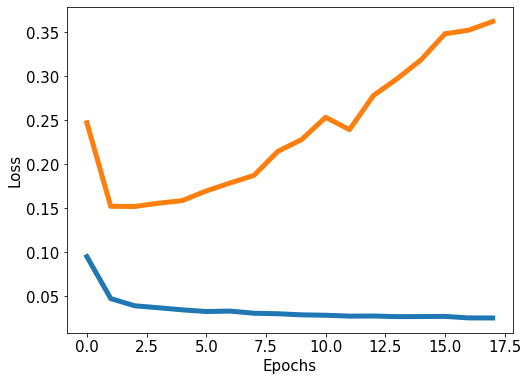

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
lstm_model.evaluate(wide_window.test)

61/61 [==============================] - 0s 6ms/step - loss: 0.3227 - mean_absolute_error: 0.4487


[0.3226853609085083, 0.44870468974113464]

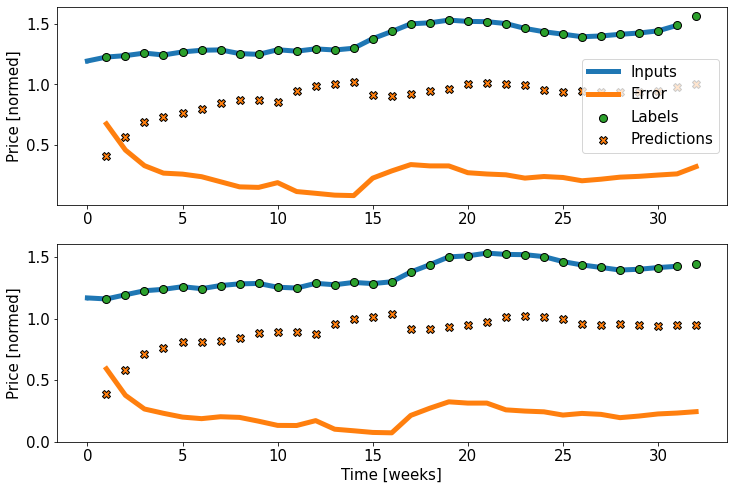

In [ ]:
wide_window.plot(lstm_model, plot_col='Price')